In [83]:
import torch
import cv2
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights
import torchvision

import matplotlib.pyplot as plt
import numpy as np

In [84]:
LABEL = 37

In [85]:
# 2. load image
im_raw = cv2.imread("Football.jpg")
im_np = im_raw.copy()

In [86]:
# reduce resolution
height, width, _ = im_raw.shape
im_resized = cv2.resize(im_raw, (256,128))

In [87]:
# 3. Change image to tensor of given type
im_resized = torch.from_numpy(im_resized).type(torch.float32)
X = im_resized.permute(2, 0, 1)

# 4. Conver image values to range 0 to 1
Xmin = torch.min(X)
Xmax = torch.max(X)
X = X - Xmin
X = X / Xmax
X = torch.unsqueeze(X, 0)
X, X.shape

(tensor([[[[0.1151, 0.1151, 0.1071,  ..., 0.2500, 0.2817, 0.2937],
           [0.1111, 0.1032, 0.1190,  ..., 0.1825, 0.1706, 0.1825],
           [0.1190, 0.1151, 0.0952,  ..., 0.2063, 0.2222, 0.2738],
           ...,
           [0.2540, 0.2183, 0.2460,  ..., 0.2778, 0.2698, 0.2460],
           [0.2024, 0.2222, 0.2262,  ..., 0.2817, 0.3175, 0.2738],
           [0.2460, 0.2341, 0.2341,  ..., 0.3413, 0.3095, 0.3056]],
 
          [[0.0992, 0.0833, 0.0714,  ..., 0.2421, 0.2540, 0.2817],
           [0.0833, 0.0635, 0.0794,  ..., 0.1429, 0.1310, 0.1468],
           [0.1032, 0.0675, 0.0437,  ..., 0.1746, 0.1786, 0.2103],
           ...,
           [0.3849, 0.3571, 0.3730,  ..., 0.3651, 0.3690, 0.3651],
           [0.3175, 0.3373, 0.3294,  ..., 0.4206, 0.4484, 0.3929],
           [0.3651, 0.3611, 0.3452,  ..., 0.4524, 0.4127, 0.4008]],
 
          [[0.1468, 0.1270, 0.1111,  ..., 0.2738, 0.2937, 0.3214],
           [0.1429, 0.1111, 0.1270,  ..., 0.1944, 0.1825, 0.1984],
           [0.1627, 0.11

In [88]:
import onnx

onnx_model = onnx.load("../../model.onnx")
onnx.checker.check_model(onnx_model)

In [89]:
import onnxruntime as ort
import numpy as np

ort_sess = ort.InferenceSession("../../model.onnx")
outputs = ort_sess.run(None, {'input': X.cpu().numpy()})
outputs


[array([[1.72121521e+02, 2.48873291e+01, 2.19625381e+02, 7.81735535e+01],
        [9.99088097e+00, 1.95777702e+01, 6.40015411e+01, 1.14245758e+02],
        [9.75724106e+01, 2.97607746e+01, 1.93396072e+02, 1.07490662e+02],
        [1.82845026e-01, 3.46997070e+01, 2.83716545e+01, 1.15959793e+02],
        [2.13553879e+02, 1.86760845e+01, 2.22656082e+02, 3.77711143e+01],
        [2.04171463e+02, 1.71347046e+01, 2.16680557e+02, 4.01651688e+01],
        [1.96814453e+02, 9.76584549e+01, 2.12583572e+02, 1.08945618e+02],
        [1.59286957e+02, 5.16374397e+01, 1.83571701e+02, 6.06505318e+01],
        [2.37823105e+01, 2.13183842e+01, 6.28503914e+01, 7.96487045e+01],
        [9.05549393e+01, 4.40546722e+01, 1.31069046e+02, 6.73254700e+01],
        [1.84580231e+02, 1.02813362e+02, 2.54427933e+02, 1.12018242e+02],
        [1.73499878e+02, 3.19826660e+01, 1.86377197e+02, 7.66094208e+01],
        [1.97907166e+02, 9.76066055e+01, 2.12816208e+02, 1.08648674e+02],
        [3.44324760e+01, 2.19634857e+0

In [90]:
mask_np = None

for i, label in enumerate(outputs[1]):
    if label == LABEL:
        mask_np = outputs[3][i]
        break

mask_np = np.transpose(mask_np, (1, 2, 0))
mask_np = cv2.resize(mask_np, (width, height))
mask_np.shape

(814, 1197)

In [91]:
mask_tensor = torch.from_numpy(mask_np)
mask_tensor = mask_tensor * Xmax
mask_tensor = mask_tensor + Xmin
mask_tensor[mask_tensor < 0] = 0
mask_tensor[mask_tensor > 255] = 255
mask_tensor = mask_tensor.type(torch.uint8)


In [92]:
mask_np = mask_tensor.cpu().numpy()

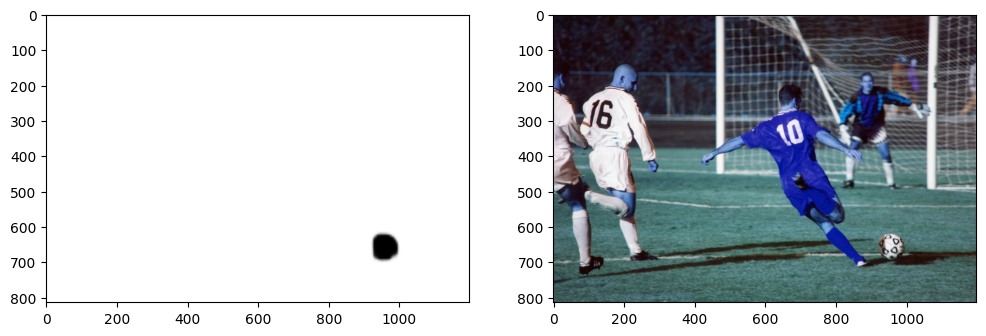

In [93]:
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.imshow(mask_np, cmap="Grays")
plt.subplot(1, 2, 2)
plt.imshow(im_np)
plt.show()

In [99]:
# 12. Get contours from the mask
contours, hierarchy = cv2.findContours(mask_np, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnt = sorted(contours, key=cv2.contourArea)[-1]

# 13. Getting proper mask from contours
mask = np.zeros((im_np.shape[0], im_np.shape[1]), dtype="uint8")
cv2.drawContours(mask, [cnt], -1, 255, -1)
mask= cv2.bitwise_not(mask)

# 14. Putting mask on the image
finalImage = cv2.bitwise_and(im_np, im_np, mask = mask)

In [100]:
# 15. Display finalImage
cv2.imshow("masked car", finalImage)
cv2.waitKey(0)
cv2.destroyAllWindows() 